In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using DiffResults
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using Optim: InverseDiagonal
using MLDataUtils
using Test
using ProgressMeter
using Plots

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1260


In [67]:
Ne = 1000
Nx = 2
m = 30

X = sample_banana(Ne);

In [68]:
M = HermiteMap(m, X; diag = true);

In [69]:
optimize(M, X, "kfold"; withconstant = true)

HermiteMap(30, 2, LinearTransform(2, [0.007047319623587922, 0.9432096807506852], [0.9696631956663945 0.0; 0.0 1.6659385161220823], true), MapComponent[MapComponent(30, 1, 1, IntegratedFunction(30, 1, 1, Rectifier("softplus"), ParametricFunction(ExpandedFunction(30, 1, 1, MultiBasis(Basis of 30 functions:
, 1), [1], [0.004330938578422549]))), 1.0e-6), MapComponent(30, 11, 2, IntegratedFunction(30, 11, 2, Rectifier("softplus"), ParametricFunction(ExpandedFunction(30, 11, 2, MultiBasis(Basis of 30 functions:
, 2), [1 0; 0 1; … ; 0 7; 0 8], [19.559655982528486, -21.01494313594569, 3.5502725950753438, -12.65428060456695, -0.18440104198370527, 1.2647511368807984, -6.574893993284202, 4.441598717229876, -1.6097162694159208, -1.7479706600006866, -1.440459354951554]))), 1.0e-6)])

In [70]:
MpushX = evaluate(M, X)

2×1000 Array{Float64,2}:
 -0.584899  -1.09483   -1.02898   -0.106933  …  -2.35579  -0.402645   1.96129
 -0.657921   0.947146  -0.550495   0.047086      2.02238  -0.102477  -2.212

In [71]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [72]:
Nlog = 50
logbanana = zeros(Nlog, Nlog)
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)


xrange = range(-4.0; stop = 4.0, length = Nlog)
yrange = range(-4.0; stop = 4.0, length = Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y])
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [73]:
norm(exp.(logbanana)' - exp.(logbanana_approx)')/norm(exp.(logbanana)')

0.09809159607760529

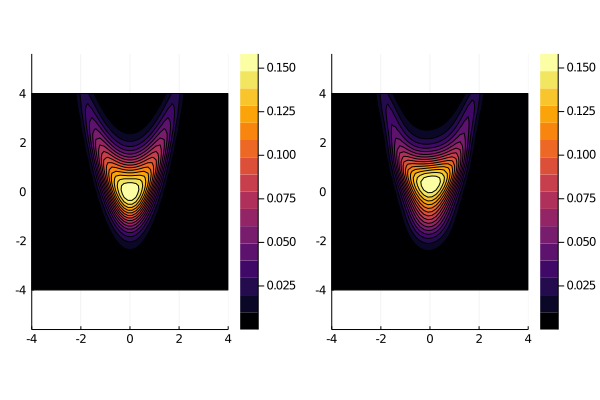

In [74]:
plt = plot(layout = grid(1,2))
contourf!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contourf!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

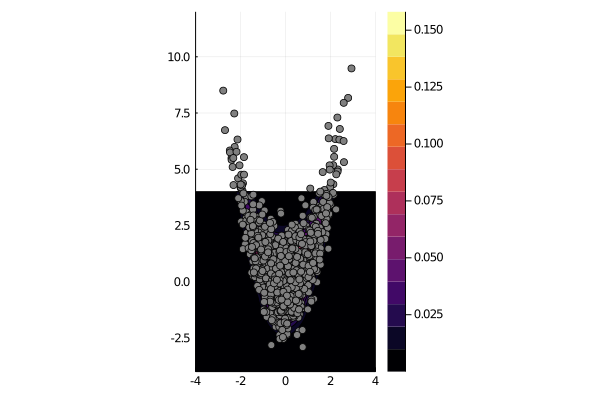

In [75]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf), ylim = (-4, 12))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey, ratio = 1)

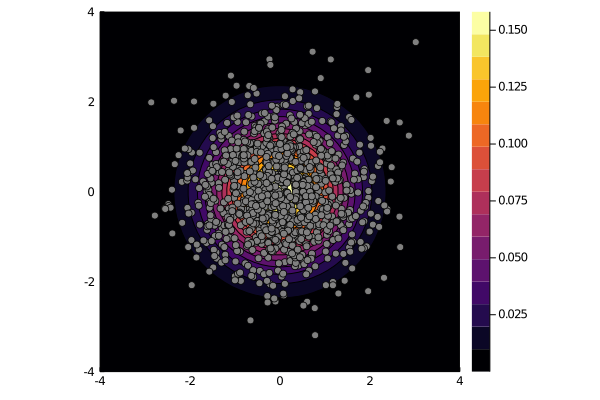

In [76]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [77]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 0.002484496109979758
 0.0032735154204118553

In [78]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
 0.999992    0.00935871
 0.00935871  1.01407